In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.autograd import grad
import torchaudio
from torchaudio.transforms import MelSpectrogram
import numpy as np
from functools import partial
from scipy.signal.windows import boxcar
import kazane
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib import rc
from torch_fftconv import fft_conv1d
from models import UnconditionalDiffWave, CosineScheduler, NoiseScheduler, NuWave, LogSNRLinearScheduler
from utils.utils import gamma2logas, beta2gamma, gamma2as
import librosa
import librosa.display as display
from tqdm import tqdm
import IPython.display as ipd
from pathlib import Path

from vctk_infer import STFTDecimate, reverse, reverse_manifold, nuwave_reverse
from inference import reverse_process_new

rc('animation', html='html5')
device = torch.device('cuda:0')

# Hyper Parameters

In [2]:
T = 200

q = 6
roll_off = 0.962
num_zeros = 128
n_fft = 2048
hop_length = 512
window_func = partial(torch.kaiser_window, periodic=False,
                      beta=14.769656459379492)

checkpoint = 'outputs/2022-05-30/00-41-21/saved/training_checkpoint_500000.pt'
nuwave_checkpoint = '/home/ycy/data-disk/DeepLearning/nuwave/checkpoints/checkpoints_nuwave_x3/nuwave_x3_01_10_23_epoch=653_EMA'
# nuwave_checkpoint = '/home/ycy/data-disk/DeepLearning/nuwave/checkpoints/checkpoints_nuwave_x2/nuwave_x2_01_07_22_epoch=645_EMA'

kwargs = {
    'q': q,
    'roll_off': roll_off,
    'num_zeros': num_zeros,
    'window_func': window_func,
}

test_file = '/home/ycy/data-disk/Datasets/VCTK-Corpus-0.92/wav48_silence_trimmed/test/p360/p360_001_mic1.wav'

# Utilities

In [3]:
def lsd(y_hat, y):
    window = torch.hann_window(2048, device=y.device)
    Y_hat = torch.stft(y_hat, 2048, hop_length=512, window=window, return_complex=True)
    Y = torch.stft(y, 2048, hop_length=512, window=window, return_complex=True)
    sp = Y_hat.abs().square_().clamp_(min=1e-8).log10_()
    st = Y.abs().square_().clamp_(min=1e-8).log10_()
    return (sp - st).square_().mean(0).sqrt_().mean()

# Load Model Weights

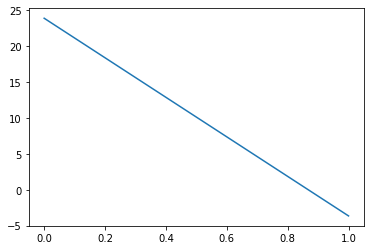

NuWave(
  (input_projection): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (low_projection): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (diffusion_embedding): DiffusionEmbedding(
    (projection1): Linear(in_features=128, out_features=512, bias=True)
    (projection2): Linear(in_features=512, out_features=512, bias=True)
  )
  (residual_layers): ModuleList(
    (0): ResidualBlock(
      (dilated_conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (diffusion_projection): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (low_projection): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ResidualBlock(
      (dilated_conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (diffusion_projection): Linear(in_features=512, out_features=64, bias=True)
      (output_projection): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  

In [4]:

state_dict = torch.load(checkpoint, map_location='cpu')
model = UnconditionalDiffWave(T=1, cycle_length=10, dilation_base=2, layers=30)
model.load_state_dict(state_dict['ema_model'])
model = model.to(device)
model.eval()

scheduler = LogSNRLinearScheduler().to(device)
scheduler.load_state_dict(state_dict['noise_scheduler'])

t = torch.linspace(0, 1, T).to(device)
# gamma = -23 + (23 + 3.6) * t
# steps = t
with torch.no_grad():
    gamma, steps = scheduler(t)
plt.plot(t.cpu().numpy(), -gamma.cpu().numpy(), label='gamma')
# plt.ylim(-5, 10)
plt.show()

# short_gamma = beta2gamma(torch.tensor(
# [1e-6, 2e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.9], device=device))

# t = (gamma[:, None] - short_gamma).abs().argmin(0) / (T + 1)
# t = torch.cat([t.new_zeros(1), t], 0)
# print(t)
# with torch.no_grad():
#     gamma, steps = scheduler(t)
state_dict = torch.load(nuwave_checkpoint, map_location='cpu')
state_dict = dict((x[6:], y) for x, y in state_dict.items() if x.startswith('model.'))

nuwave = NuWave()
nuwave.load_state_dict(state_dict)
nuwave = nuwave.to(device)
nuwave.eval()

# Log-SNR Curve from NU-Wave

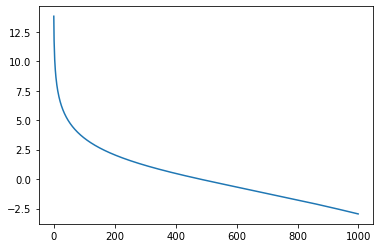

tensor(13.8155, dtype=torch.float64) tensor(-2.9558, dtype=torch.float64)


In [5]:
beta = torch.linspace(1e-6, 0.006, 1000, dtype=torch.float64)
a = 1 - beta
a = a.cumprod(0)
sigma = 1 - a
snr = a.log() - sigma.log()
plt.plot(snr.numpy())
plt.show()
print(snr[0], snr[-1])

# Load Test File

In [6]:
y, sr = torchaudio.load(test_file)
# y = torchaudio.functional.highpass_biquad(y, sr, 20, Q=0.1)
y = y.to(device).mean(0)
y = y[:y.numel() // q * q]
ipd.Audio(y.cpu().numpy(), rate=sr)

# Build Sinc Resamplers

torch.Size([288000])


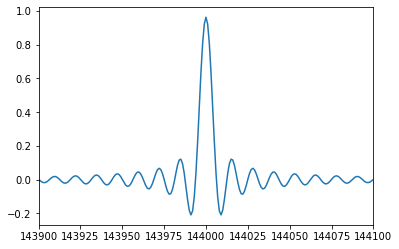

In [7]:
decimater=kazane.Decimate(**kwargs).to(device)
# decimater = STFTDecimate(q).to(device)
upsampler=kazane.Upsample(**kwargs).to(device)
linear_upsampler = torch.nn.Upsample(scale_factor=q, mode='linear', align_corners=False)

# print(decimater.kernel.size(), upsampler.kernel.size())

impulse=torch.zeros(sr, device = device)
impulse[sr // 2]=1
upsampled_impulse=upsampler(impulse.view(1, 1, -1)).squeeze()
print(upsampled_impulse.shape)

plt.plot(upsampled_impulse.cpu().numpy())
plt.xlim(sr // 2 * q - 100, sr // 2 * q + 100)
plt.show()

## Frequency Response of Sinc Filter

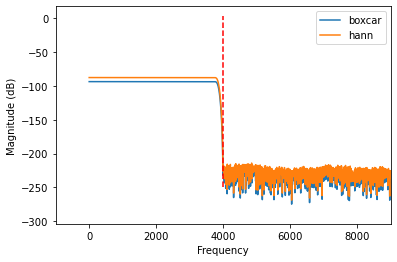

In [8]:
plt.magnitude_spectrum(upsampled_impulse.cpu().numpy(), Fs=sr, scale='dB', window=boxcar(upsampled_impulse.shape[0]), label='boxcar')
plt.magnitude_spectrum(upsampled_impulse.cpu().numpy(), Fs=sr, scale='dB', label='hann')
plt.legend()
# plt.ylim(-200, -60)
plt.xlim(sr / q / 2 - 5000, sr / q / 2 + 5000)
plt.vlines(sr / q /2, -250, 3, colors='r', linestyles='dashed')
plt.show()

## Apply the Sinc Filter Twice

torch.Size([289536]) torch.Size([1537])


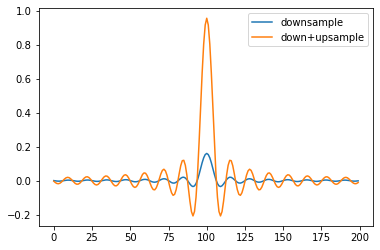

In [9]:
first_sinc_kernel = decimater.kernel.squeeze()
second_sinc_kernel = upsampled_impulse
double_sinc_kernel = fft_conv1d(first_sinc_kernel.view(1, 1, -1), second_sinc_kernel.view(1, 1, -1), padding=second_sinc_kernel.shape[0] - 1).squeeze()
print(double_sinc_kernel.shape, first_sinc_kernel.shape)

plt.plot(first_sinc_kernel.cpu().numpy()[first_sinc_kernel.size(0) // 2 - 100:first_sinc_kernel.size(0) // 2 + 100], label='downsample')
plt.plot(double_sinc_kernel.cpu().numpy()[double_sinc_kernel.size(0) // 2 - 101:double_sinc_kernel.size(0) // 2 + 99], label='down+upsample')
plt.legend()
plt.show()

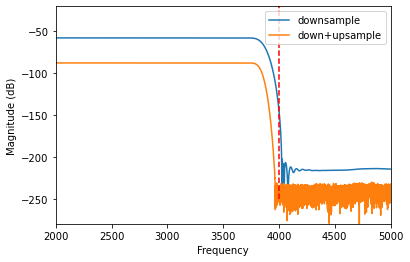

In [10]:
plt.magnitude_spectrum(first_sinc_kernel.cpu().numpy(), pad_to=262144, Fs=sr, scale='dB', label='downsample')
plt.magnitude_spectrum(double_sinc_kernel.cpu().numpy(), pad_to=262144, Fs=sr, scale='dB', label='down+upsample')
plt.legend()
plt.ylim(-280, -20)
plt.xlim(sr / 2 / q - 2000, sr / 2 / q + 1000)
plt.vlines(sr/2 / q, -250, 3, colors='r', linestyles='dashed')
plt.show()

torch.Size([104568]) torch.Size([104568])


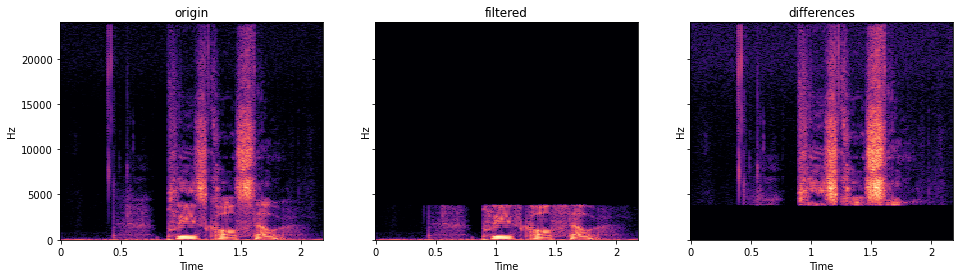

In [11]:
y_hat = upsampler(decimater(y)).squeeze()
diff = y_hat - y
print(y_hat.shape, y.shape)


fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16, 4))
img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[0])
ax[0].set_title('origin')
                                                                                                                                
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hat.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
ax[1].set_title('filtered')
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(diff.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[2])
ax[2].set_title('differences')
plt.show()

In [12]:
ipd.Audio(y_hat.cpu().numpy(), rate=sr)

# Reconstruction

## Ours (UDM)

In [15]:
y_recon_ours = reverse_manifold(y_hat.unsqueeze(0), gamma,
downsample=amp.autocast()(lambda x: decimater(x)),
upsample=amp.autocast()(lambda x: upsampler(x)),
lr=0.5,
inference_func=amp.autocast()(lambda x, t, index: model(x, steps[t:t+1]))).squeeze()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:25<00:00,  7.81it/s]


In [16]:
ipd.Audio(y_recon_ours.cpu().numpy(), rate=sr)

## NU-Wave

In [15]:
y_recon_nuwave = nuwave_reverse(linear_upsampler(decimater(y).view(1, 1, -1)).squeeze(0), gamma, amp.autocast()(nuwave)).squeeze()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:15<00:00, 12.87it/s]


In [16]:
ipd.Audio(y_recon_nuwave.cpu().numpy(), rate=sr)

## NU-Wave+

In [17]:
cond = linear_upsampler(decimater(y).view(1, 1, -1)).squeeze(0)
alpha = gamma2as(gamma)[0]
y_recon_nuwave_new = reverse_manifold(y_hat.unsqueeze(0), gamma,
downsample=amp.autocast()(lambda x: decimater(x)),
upsample=amp.autocast()(lambda x: upsampler(x)),
lr=0.25,
inference_func=amp.autocast()(lambda x, t, index: nuwave(x, cond[:, index], alpha[t:t+1]))).squeeze()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:33<00:00,  5.91it/s]


In [18]:
ipd.Audio(y_recon_nuwave_new.cpu().numpy(), rate=sr)

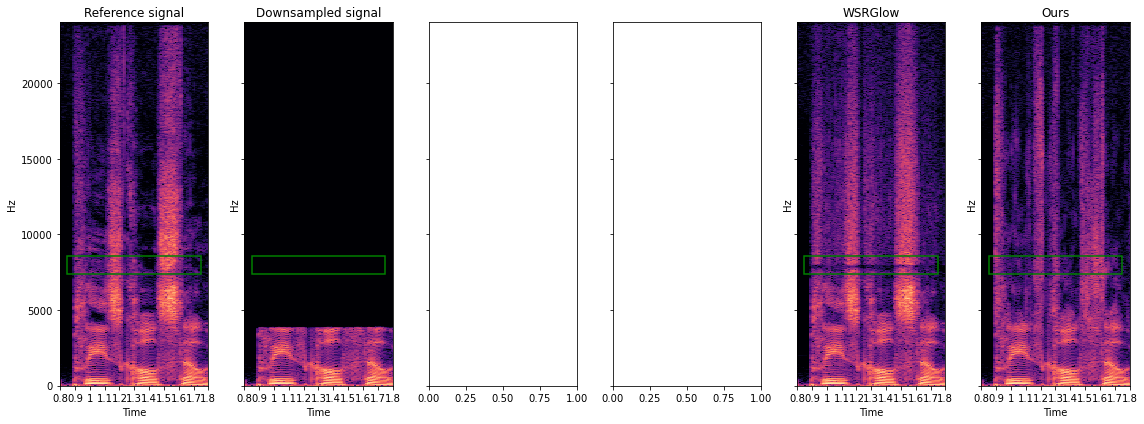

NameError: name 'y_recon_nuwave' is not defined

In [19]:
y_recon_wsrglow, _ = torchaudio.load('../constant-memory-waveglow/wsrglow_recon.wav')
y_recon_wsrglow = y_recon_wsrglow.squeeze()

fig, ax = plt.subplots(nrows=1, ncols=6, sharey=True, figsize=(16, 6))
img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[0])
ax[0].set_title("Reference signal")
ax[0].set_xlim(0.8, 1.8)
ax[0].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_hat.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
ax[1].set_title("Downsampled signal")
ax[1].set_xlim(0.8, 1.8)
ax[1].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))
# display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon_nuwave.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
#                                          ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[2])
# ax[2].set_title("NU-Wave")
# ax[2].set_xlim(0.8, 1.8)
# ax[2].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))
# img3 = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon_nuwave_new.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
#                                          ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[3])
# ax[3].set_title("NU-Wave+")
# ax[3].set_xlim(0.8, 1.8)
# ax[3].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))

display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon_wsrglow.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[4])
ax[4].set_title("WSRGlow")
ax[4].set_xlim(0.8, 1.8)
ax[4].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))

display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y_recon_ours.cpu().numpy(), n_fft=n_fft, hop_length=hop_length)),
                                         ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[5])
ax[5].set_title("Ours")
ax[5].set_xlim(0.8, 1.8)
ax[5].add_patch(patches.Rectangle((0.85, 7400), 0.9, 1200, linewidth=1.5, edgecolor='g', facecolor='none'))


# fig.colorbar(img3, ax=ax)
plt.tight_layout()
plt.savefig(f"comparison_T{T}_sinc.eps", format='eps')
plt.show()

print(lsd(y_recon_ours, y), lsd(y_recon_nuwave, y), lsd(y_recon_wsrglow.cuda(), y))

# Animation

In [52]:
y_recon, inters = reverse_manifold(y_hat.unsqueeze(0), gamma,
downsample=amp.autocast()(lambda x: decimater(x)),
upsample=amp.autocast()(lambda x: upsampler(x)),
                           lr=50 / T * q / 3,
inference_func=amp.autocast()(lambda x, t, _: model(x, steps[t:t+1])),
inter_results=True)
y_recon = y_recon.squeeze()
inters = [x.cpu().squeeze().numpy() for x in inters] + [y_recon.cpu().numpy()]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:25<00:00,  7.74it/s]


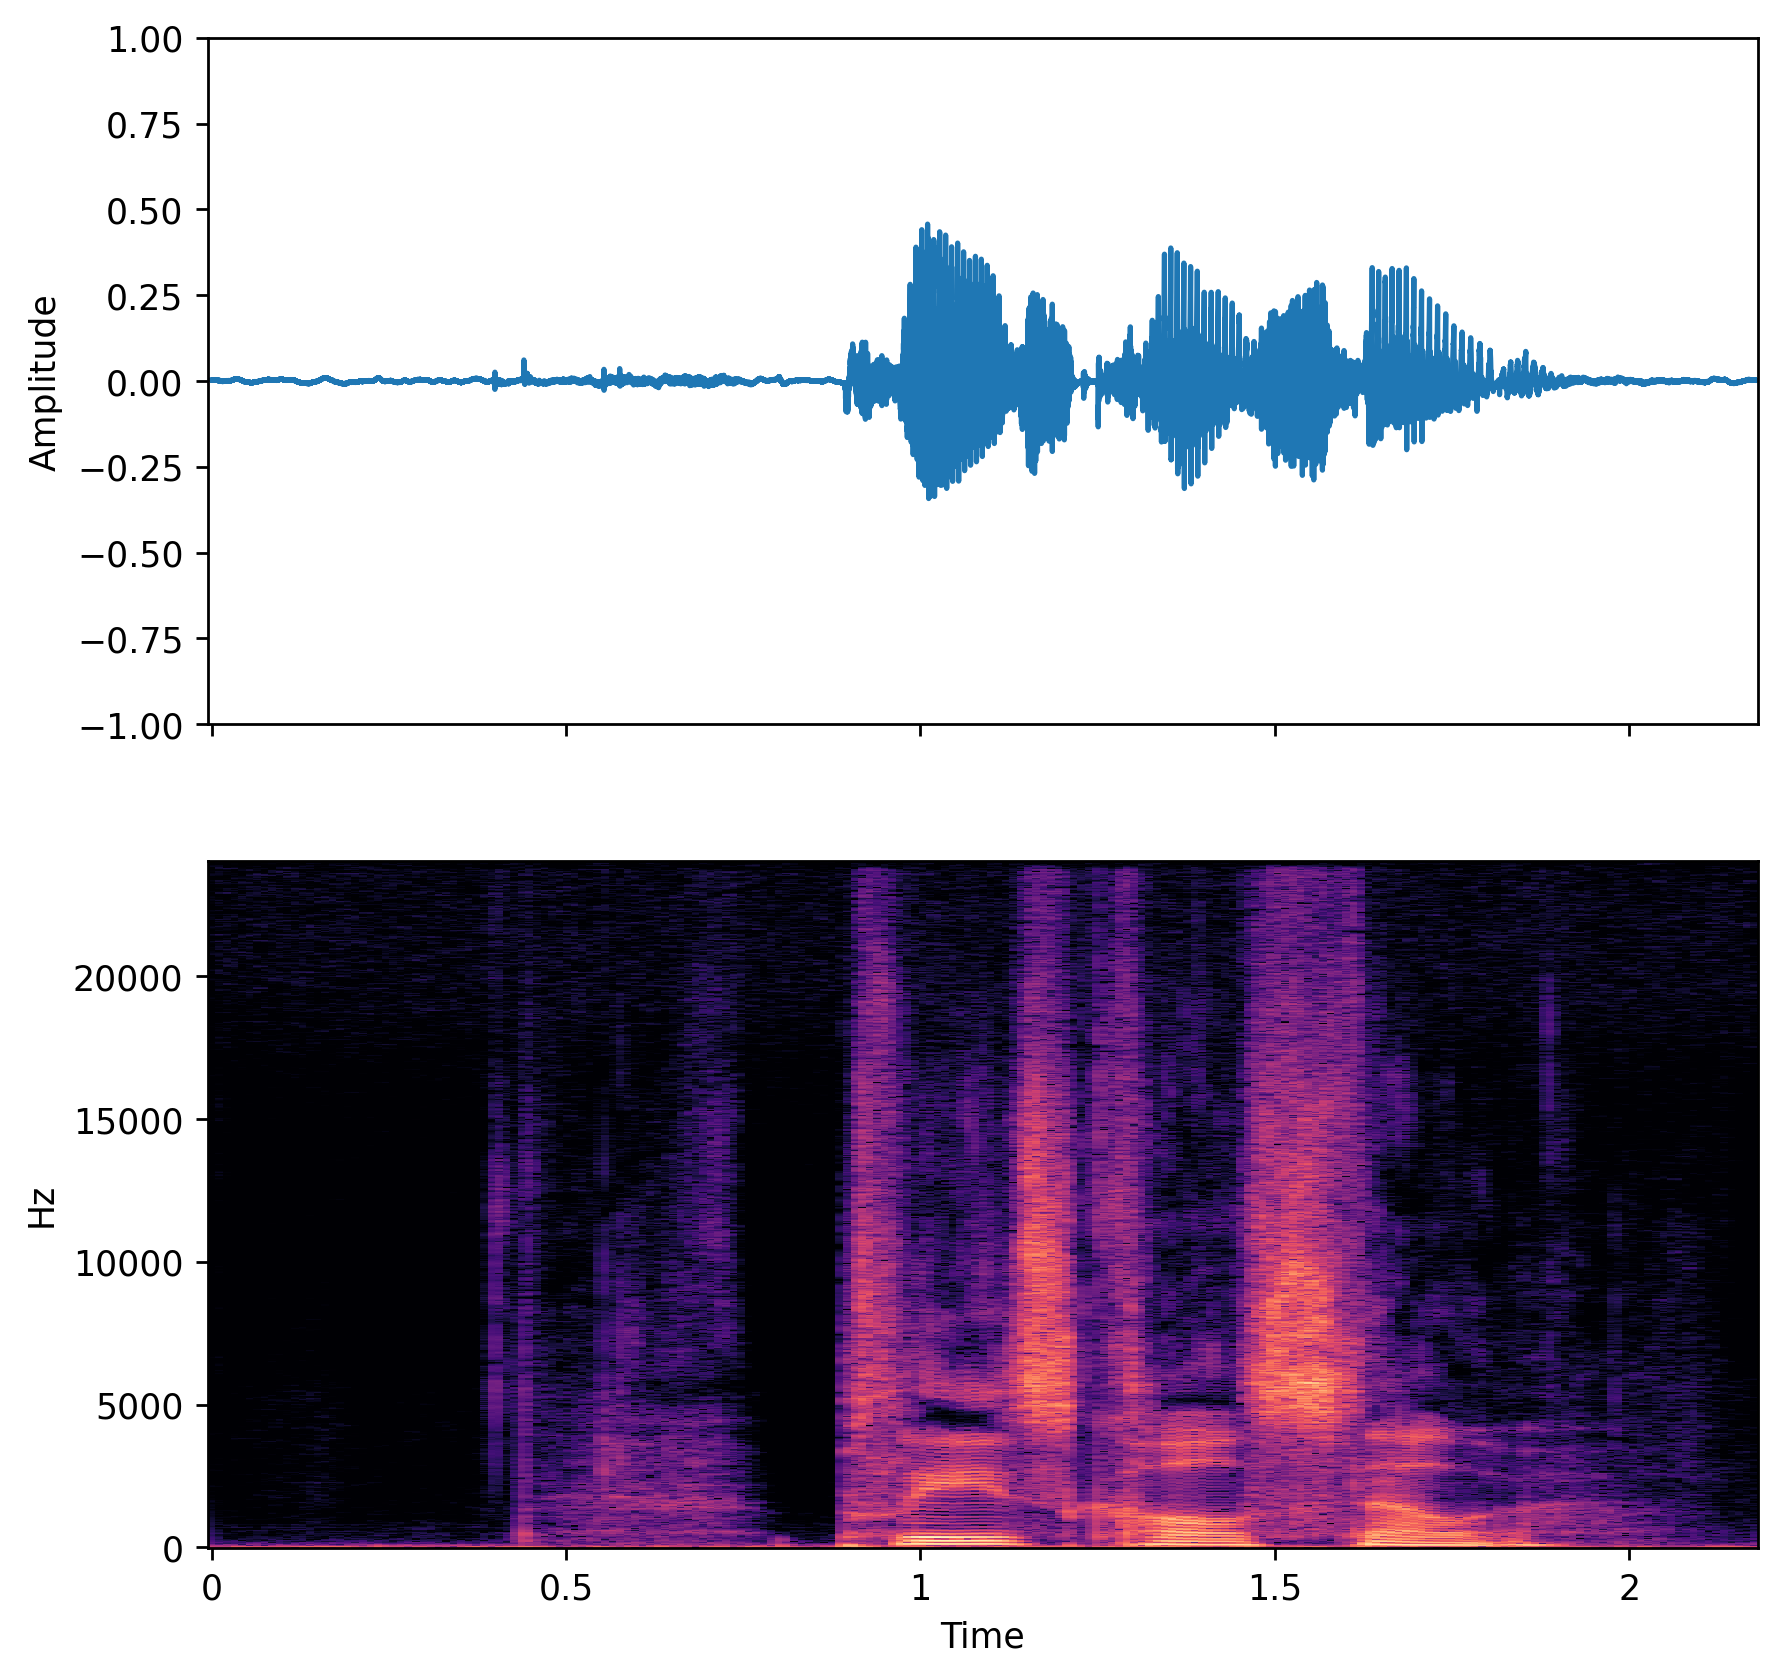

In [53]:
fig = plt.figure(dpi=250, figsize=(8, 8))#dpi=100, figsize=(12, 12))
ax = fig.subplots(2, 1, sharex=True)
t = np.arange(y_recon.shape[0]) / sr
images = []
for i in range(T):
    line, =  ax[0].plot(t, inters[i], c='C0')
    ax[0].set_ylabel("Amplitude")
    ax[0].set_ylim(-1, 1)
    img = display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(inters[i], n_fft=n_fft, hop_length=hop_length)),
                                               ref=np.max), y_axis='linear', x_axis='time', sr=sr, hop_length=hop_length, ax=ax[1])
    images.append([line, img])

ani = animation.ArtistAnimation(fig, images, interval=1000 / 24)
    
ani.save("generation.mp4")

# def init():
#     ax.set_ylim(-1, 1)
#     ax.set_ylabel("Amplitude")
#     ax.set_xlabel("Seconds")
#     return

# def update(frame):
#     ax.collections.clear()
#     l = inters[frame]
#     line.set_ydata(l)
#     return

# ani = animation.FuncAnimation(
#     fig, update, init_func=init, frames=T, interval=1000 / 24)
# ani.save("generation.mp4")